# Monte Carlo Simulation "How Many"
## Context
> *Describe the context of or the reason for this analysis.*

At our planning on 28th January 2018 Jacob remarked that the planned scope of six work items is maybe too large for the next 14-day sprint. Before we make a commitment for a scope and a given delivery date, we have to forecast possible scopes of work items and related risk levels.

## Idea
> *Document ideas and data collection.*

To understand the current delivery capability, we tracked our throughput and cycle times of our work items in the issue tracking tool [Jira](https://de.atlassian.com/software/jira). The measurement took place between 13th July 2018 and 30th January 2019. The results were exported into a CSV file using the [Jira-to-Analytics](https://github.com/ActionableAgile/jira-to-analytics) command line tool with the following configuration:
```
[...]
Criteria:
    Project: 
        - DATA
    Issue types: 
        - Story
        - Task
        - Bug
    Start Date: 2018-07-13
    End Date: 2019-01-30

Workflow:
[...]

```
The CSV file contains all work items that were created and moved through during the measurement’s time span. We just take the relevant data of completed work items.

In [1]:
import pandas as pd
date_columns = ['Backlog', 'In Analysis', 'Ready for Development', 'In Sign Off', 'Done']
kanban_data = pd.read_csv('data.csv', parse_dates=date_columns)
kanban_data = kanban_data[['Done', 'Type']].dropna()
kanban_data.head(2)

,Done,Type
0,2018-09-26,Story
1,2018-09-13,Story


## Analysis
> *Document assumptions and heuristics and make calculations understandable.*

Based on the past throughput per day a forecast can be created with a monte carlo simulation. The throughput is the total amount of completed work items per day.

### Calculate Throughput Data
Therefore, we sum up the completed work items per day and add the missing dates with zero throughput. We plot the data of the throughput per day to get a brief overview of the result.

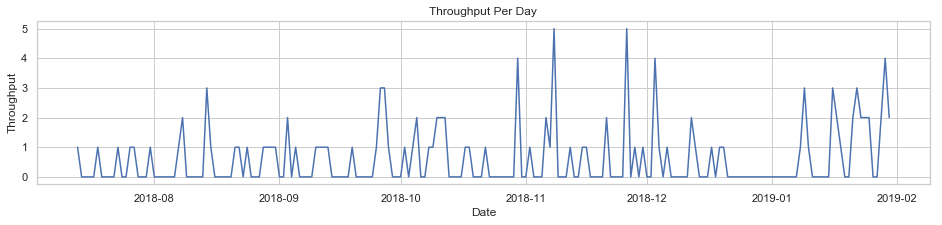

In [2]:
throughput = pd.crosstab(kanban_data.Done, kanban_data.Type, colnames=[None]).reset_index()
throughput['Throughput'] = throughput.Bug + throughput.Story + throughput.Task
date_range = pd.date_range(start=throughput.Done.min(), end=throughput.Done.max())
throughput = throughput.set_index('Done').reindex(date_range).fillna(0).astype(int).rename_axis('Date')

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
sns.set(style="whitegrid", rc={'figure.figsize':(16,3)})
sns.lineplot(x='Date', y='Throughput', data=throughput.reset_index()).set_title("Throughput Per Day");

### Distribution of the Monte Carlo Simulation 'How Many Items'
Based on the throughput data we simulate the given time span multiple times. We set the number of past days to select the data that we want to rely on. We set the number of days to simulate. We plot the simulation results to get a brief overview of distribution of total items completed in the given timespan.

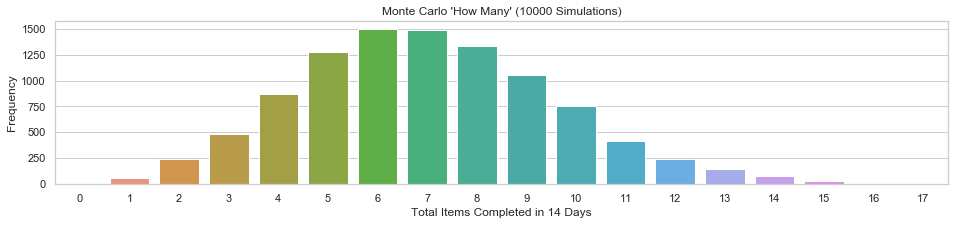

In [6]:
### SETTINGS ####
PAST_DAYS = 100
DAYS_TO_SIMULATE = 14
SIMULATIONS = 10000
#################
dataset = throughput[['Throughput']][: PAST_DAYS].reset_index(drop=True)
samples = [dataset.sample(n=DAYS_TO_SIMULATE).sum().Throughput for i in range(SIMULATIONS)]
samples = pd.DataFrame(samples, columns=['Items'])
distribution = samples.groupby(['Items']).size().reset_index(name='Frequency')
sns.set(style="whitegrid", rc={'figure.figsize':(16,3)})
ax = sns.barplot(x = 'Items', y = 'Frequency', data=distribution)
ax.set_title("Monte Carlo 'How Many' (%d Simulations)" % SIMULATIONS)
ax.set(xlabel='Total Items Completed in %d Days' % DAYS_TO_SIMULATE);

### 'How Many' Forecast with Probabilities
We determine the probability for each number of completed items by cumulating the frequency in the simulations. We plot the probability for each number of completed items and indicate the percentiles 70%, 85%, and 95%.

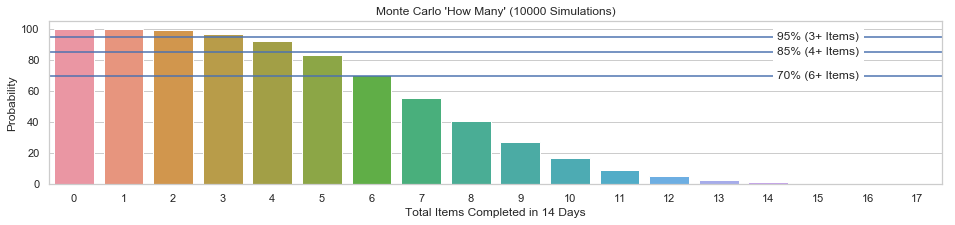

In [7]:
distribution = distribution.sort_index(ascending=False)
distribution['Probability'] = 100*distribution.Frequency.cumsum()/distribution.Frequency.sum()
sns.set(style="whitegrid", rc={'figure.figsize':(16,3)})
ax = sns.barplot(x = 'Items', y = 'Probability', data=distribution)
ax.set_title("Monte Carlo 'How Many' (%d Simulations)" % SIMULATIONS)
ax.set(xlabel='Total Items Completed in %d Days' % DAYS_TO_SIMULATE);
ax.axhline(70)
ax.axhline(85)
ax.axhline(95)
label_xpos = distribution['Items'].max()-2
ax.text(y=70, x=label_xpos, s='70%% (%d+ Items)' % samples.Items.quantile(0.3), va='center', ha='center', backgroundcolor='w')
ax.text(y=85, x=label_xpos, s='85%% (%d+ Items)' % samples.Items.quantile(0.15), va='center', ha='center', backgroundcolor='w')
ax.text(y=95, x=label_xpos, s='95%% (%d+ Items)' % samples.Items.quantile(0.05), va='center', ha='center', backgroundcolor='w');

The monte carlo simulation shows that in the timespan of *14* days...
* we can complete ***3*+ items** with a probability of **95%**.
* we can complete ***4*+ items** with a probability of **85%**.
* we can complete ***5*+ items** with a probability of **70%**.

## Conclusion
> *Write conclusive summaries and maybe support them with visualization.*

A scope of six work items for 14 days is too risky and the scope should be reduced to at least 5 items.